CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?
- ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.


분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?
- CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.


인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?
- CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

In [1]:
import os
import shutil
import scipy.io as sio
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

c:\Users\user\anaconda3\envs\aiffel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


1) 데이터 셋 준비

In [3]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 경로 (재구성한 ImageFolder 형식)
train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')
# Annotation 폴더 경로 (예: '/root/Annotation')
annotation_dir = os.path.join('./class_activation_map/Annotation')

# 커스텀 데이터셋 생성: image, label, bbox 반환
train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


2) 물체의 위치 정보

In [5]:
# Annotation 폴더에서 데이터를 골라보세요
annotation_path = os.path.join('./class_activation_map/Annotation/n02085620-Chihuahua/n02085620_10074')


# XML 파일 파싱
tree = ET.parse(annotation_path)
root = tree.getroot()

for elem in root.iter():
    print(f"{elem.tag}: {elem.text}")

annotation: 
	
folder: 02085620
filename: n02085620_10074
source: 
		
database: ImageNet database
size: 
		
width: 333
height: 500
depth: 3
segment: 0
object: 
		
name: Chihuahua
pose: Unspecified
truncated: 0
difficult: 0
bndbox: 
			
xmin: 25
ymin: 10
xmax: 276
ymax: 498


3) CAM을 위한 모델 만들기

In [6]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

c:\Users\user\anaconda3\envs\aiffel\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\aiffel\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

4) cam 모델 학습하기

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Epoch 1/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.22batch/s, avg_loss=3.2305, step_loss=1.7153]



✅ [Train] Epoch 1 완료 - Loss: 3.2273, Accuracy: 22.01%


Epoch 1/30 (Valid): 100%|██████████| 715/715 [00:40<00:00, 17.59batch/s, loss=2.7012]


⭐ [Validation] Epoch 1 완료 - Loss: 2.6278, Accuracy: 33.19%


Epoch 2/30 (Train): 100%|██████████| 1000/1000 [00:51<00:00, 19.58batch/s, avg_loss=2.2354, step_loss=2.4380]



✅ [Train] Epoch 2 완료 - Loss: 2.2331, Accuracy: 38.68%


Epoch 2/30 (Valid): 100%|██████████| 715/715 [00:40<00:00, 17.72batch/s, loss=1.6817]


⭐ [Validation] Epoch 2 완료 - Loss: 2.3803, Accuracy: 38.23%


Epoch 3/30 (Train): 100%|██████████| 1000/1000 [00:50<00:00, 19.62batch/s, avg_loss=1.7724, step_loss=1.3360]



✅ [Train] Epoch 3 완료 - Loss: 1.7706, Accuracy: 49.41%


Epoch 3/30 (Valid): 100%|██████████| 715/715 [00:39<00:00, 18.22batch/s, loss=1.3105]


⭐ [Validation] Epoch 3 완료 - Loss: 2.0728, Accuracy: 45.94%


Epoch 4/30 (Train): 100%|██████████| 1000/1000 [00:51<00:00, 19.54batch/s, avg_loss=1.3936, step_loss=2.1294]



✅ [Train] Epoch 4 완료 - Loss: 1.3922, Accuracy: 58.38%


Epoch 4/30 (Valid): 100%|██████████| 715/715 [00:40<00:00, 17.62batch/s, loss=1.0654]


⭐ [Validation] Epoch 4 완료 - Loss: 2.2681, Accuracy: 44.39%


Epoch 5/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.16batch/s, avg_loss=1.1144, step_loss=1.0744]



✅ [Train] Epoch 5 완료 - Loss: 1.1133, Accuracy: 65.53%


Epoch 5/30 (Valid): 100%|██████████| 715/715 [00:39<00:00, 17.88batch/s, loss=1.4125]


⭐ [Validation] Epoch 5 완료 - Loss: 2.2282, Accuracy: 43.52%


Epoch 6/30 (Train): 100%|██████████| 1000/1000 [00:51<00:00, 19.53batch/s, avg_loss=0.9055, step_loss=1.4252]



✅ [Train] Epoch 6 완료 - Loss: 0.9046, Accuracy: 71.67%


Epoch 6/30 (Valid): 100%|██████████| 715/715 [00:39<00:00, 18.04batch/s, loss=1.3486]


⭐ [Validation] Epoch 6 완료 - Loss: 1.8931, Accuracy: 52.35%


Epoch 7/30 (Train): 100%|██████████| 1000/1000 [00:51<00:00, 19.50batch/s, avg_loss=0.7044, step_loss=1.5649]



✅ [Train] Epoch 7 완료 - Loss: 0.7030, Accuracy: 77.29%


Epoch 7/30 (Valid): 100%|██████████| 715/715 [00:38<00:00, 18.48batch/s, loss=1.7578]


⭐ [Validation] Epoch 7 완료 - Loss: 1.9929, Accuracy: 51.15%


Epoch 8/30 (Train): 100%|██████████| 1000/1000 [00:50<00:00, 19.79batch/s, avg_loss=0.5391, step_loss=0.4316]



✅ [Train] Epoch 8 완료 - Loss: 0.5386, Accuracy: 82.61%


Epoch 8/30 (Valid): 100%|██████████| 715/715 [00:39<00:00, 17.89batch/s, loss=0.6320]


⭐ [Validation] Epoch 8 완료 - Loss: 1.9775, Accuracy: 52.05%


Epoch 9/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.06batch/s, avg_loss=0.4600, step_loss=0.9281]



✅ [Train] Epoch 9 완료 - Loss: 0.4595, Accuracy: 85.05%


Epoch 9/30 (Valid): 100%|██████████| 715/715 [00:38<00:00, 18.57batch/s, loss=0.7357]


⭐ [Validation] Epoch 9 완료 - Loss: 2.0015, Accuracy: 52.76%


Epoch 10/30 (Train): 100%|██████████| 1000/1000 [00:50<00:00, 19.68batch/s, avg_loss=0.3495, step_loss=0.6196]



✅ [Train] Epoch 10 완료 - Loss: 0.3488, Accuracy: 88.80%


Epoch 10/30 (Valid): 100%|██████████| 715/715 [00:39<00:00, 18.20batch/s, loss=0.1977]


⭐ [Validation] Epoch 10 완료 - Loss: 2.1898, Accuracy: 51.53%


Epoch 11/30 (Train): 100%|██████████| 1000/1000 [00:51<00:00, 19.52batch/s, avg_loss=0.2711, step_loss=0.3169]



✅ [Train] Epoch 11 완료 - Loss: 0.2705, Accuracy: 91.25%


Epoch 11/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.36batch/s, loss=0.3972]


⭐ [Validation] Epoch 11 완료 - Loss: 2.1900, Accuracy: 52.97%


Epoch 12/30 (Train): 100%|██████████| 1000/1000 [00:51<00:00, 19.34batch/s, avg_loss=0.2360, step_loss=0.0878]



✅ [Train] Epoch 12 완료 - Loss: 0.2358, Accuracy: 92.43%


Epoch 12/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.33batch/s, loss=0.6770]


⭐ [Validation] Epoch 12 완료 - Loss: 2.2207, Accuracy: 52.74%


Epoch 13/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.08batch/s, avg_loss=0.1632, step_loss=0.0895]



✅ [Train] Epoch 13 완료 - Loss: 0.1632, Accuracy: 95.12%


Epoch 13/30 (Valid): 100%|██████████| 715/715 [00:42<00:00, 16.94batch/s, loss=0.4574]


⭐ [Validation] Epoch 13 완료 - Loss: 2.2629, Accuracy: 55.03%


Epoch 14/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.20batch/s, avg_loss=0.1241, step_loss=0.0099]



✅ [Train] Epoch 14 완료 - Loss: 0.1240, Accuracy: 96.16%


Epoch 14/30 (Valid): 100%|██████████| 715/715 [00:42<00:00, 16.73batch/s, loss=1.3753]


⭐ [Validation] Epoch 14 완료 - Loss: 2.1267, Accuracy: 56.52%


Epoch 15/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 18.95batch/s, avg_loss=0.1077, step_loss=0.0092]



✅ [Train] Epoch 15 완료 - Loss: 0.1077, Accuracy: 96.83%


Epoch 15/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.26batch/s, loss=0.4812]


⭐ [Validation] Epoch 15 완료 - Loss: 2.0914, Accuracy: 57.41%


Epoch 16/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.06batch/s, avg_loss=0.0747, step_loss=0.0863]



✅ [Train] Epoch 16 완료 - Loss: 0.0745, Accuracy: 97.99%


Epoch 16/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.17batch/s, loss=0.4383]


⭐ [Validation] Epoch 16 완료 - Loss: 2.0092, Accuracy: 58.88%


Epoch 17/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.13batch/s, avg_loss=0.0641, step_loss=0.1387]



✅ [Train] Epoch 17 완료 - Loss: 0.0641, Accuracy: 98.25%


Epoch 17/30 (Valid): 100%|██████████| 715/715 [00:42<00:00, 16.96batch/s, loss=0.3607]


⭐ [Validation] Epoch 17 완료 - Loss: 2.0882, Accuracy: 57.41%


Epoch 18/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.10batch/s, avg_loss=0.0621, step_loss=0.0174]



✅ [Train] Epoch 18 완료 - Loss: 0.0620, Accuracy: 98.17%


Epoch 18/30 (Valid): 100%|██████████| 715/715 [00:40<00:00, 17.44batch/s, loss=0.1115]


⭐ [Validation] Epoch 18 완료 - Loss: 2.0611, Accuracy: 59.08%


Epoch 19/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.15batch/s, avg_loss=0.0456, step_loss=0.0111]



✅ [Train] Epoch 19 완료 - Loss: 0.0456, Accuracy: 98.67%


Epoch 19/30 (Valid): 100%|██████████| 715/715 [00:40<00:00, 17.78batch/s, loss=0.6731]


⭐ [Validation] Epoch 19 완료 - Loss: 2.2236, Accuracy: 57.12%


Epoch 20/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 18.94batch/s, avg_loss=0.0552, step_loss=0.3173]



✅ [Train] Epoch 20 완료 - Loss: 0.0552, Accuracy: 98.37%


Epoch 20/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.29batch/s, loss=0.1328]


⭐ [Validation] Epoch 20 완료 - Loss: 2.1571, Accuracy: 58.54%


Epoch 21/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 18.98batch/s, avg_loss=0.0343, step_loss=0.0021]



✅ [Train] Epoch 21 완료 - Loss: 0.0342, Accuracy: 99.11%


Epoch 21/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.29batch/s, loss=0.3639]


⭐ [Validation] Epoch 21 완료 - Loss: 2.0420, Accuracy: 60.19%


Epoch 22/30 (Train): 100%|██████████| 1000/1000 [00:51<00:00, 19.23batch/s, avg_loss=0.0283, step_loss=0.0051]



✅ [Train] Epoch 22 완료 - Loss: 0.0283, Accuracy: 99.18%


Epoch 22/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.04batch/s, loss=0.5797]


⭐ [Validation] Epoch 22 완료 - Loss: 2.0127, Accuracy: 60.62%


Epoch 23/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.14batch/s, avg_loss=0.0238, step_loss=0.0038]



✅ [Train] Epoch 23 완료 - Loss: 0.0238, Accuracy: 99.37%


Epoch 23/30 (Valid): 100%|██████████| 715/715 [00:40<00:00, 17.79batch/s, loss=0.3103]


⭐ [Validation] Epoch 23 완료 - Loss: 1.9497, Accuracy: 61.38%


Epoch 24/30 (Train): 100%|██████████| 1000/1000 [00:53<00:00, 18.71batch/s, avg_loss=0.0216, step_loss=0.0112]



✅ [Train] Epoch 24 완료 - Loss: 0.0216, Accuracy: 99.38%


Epoch 24/30 (Valid): 100%|██████████| 715/715 [00:42<00:00, 16.97batch/s, loss=0.3137]


⭐ [Validation] Epoch 24 완료 - Loss: 1.9732, Accuracy: 60.91%


Epoch 25/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.11batch/s, avg_loss=0.0147, step_loss=0.0005]



✅ [Train] Epoch 25 완료 - Loss: 0.0147, Accuracy: 99.59%


Epoch 25/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.19batch/s, loss=0.2704]


⭐ [Validation] Epoch 25 완료 - Loss: 1.9649, Accuracy: 61.99%


Epoch 26/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.13batch/s, avg_loss=0.0099, step_loss=0.0039]



✅ [Train] Epoch 26 완료 - Loss: 0.0099, Accuracy: 99.69%


Epoch 26/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.20batch/s, loss=0.1891]


⭐ [Validation] Epoch 26 완료 - Loss: 2.0206, Accuracy: 61.69%


Epoch 27/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.02batch/s, avg_loss=0.0091, step_loss=0.1346]



✅ [Train] Epoch 27 완료 - Loss: 0.0091, Accuracy: 99.71%


Epoch 27/30 (Valid): 100%|██████████| 715/715 [00:42<00:00, 16.80batch/s, loss=0.2751]


⭐ [Validation] Epoch 27 완료 - Loss: 2.0401, Accuracy: 62.18%


Epoch 28/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 18.90batch/s, avg_loss=0.0117, step_loss=0.0019]



✅ [Train] Epoch 28 완료 - Loss: 0.0117, Accuracy: 99.63%


Epoch 28/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.12batch/s, loss=0.2607]


⭐ [Validation] Epoch 28 완료 - Loss: 1.9546, Accuracy: 61.46%


Epoch 29/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.14batch/s, avg_loss=0.0092, step_loss=0.0030]



✅ [Train] Epoch 29 완료 - Loss: 0.0092, Accuracy: 99.70%


Epoch 29/30 (Valid): 100%|██████████| 715/715 [00:42<00:00, 16.86batch/s, loss=0.1318]


⭐ [Validation] Epoch 29 완료 - Loss: 1.9621, Accuracy: 62.37%


Epoch 30/30 (Train): 100%|██████████| 1000/1000 [00:52<00:00, 19.16batch/s, avg_loss=0.0089, step_loss=0.0006]



✅ [Train] Epoch 30 완료 - Loss: 0.0089, Accuracy: 99.69%


Epoch 30/30 (Valid): 100%|██████████| 715/715 [00:41<00:00, 17.18batch/s, loss=0.1798]


⭐ [Validation] Epoch 30 완료 - Loss: 2.0356, Accuracy: 61.86%


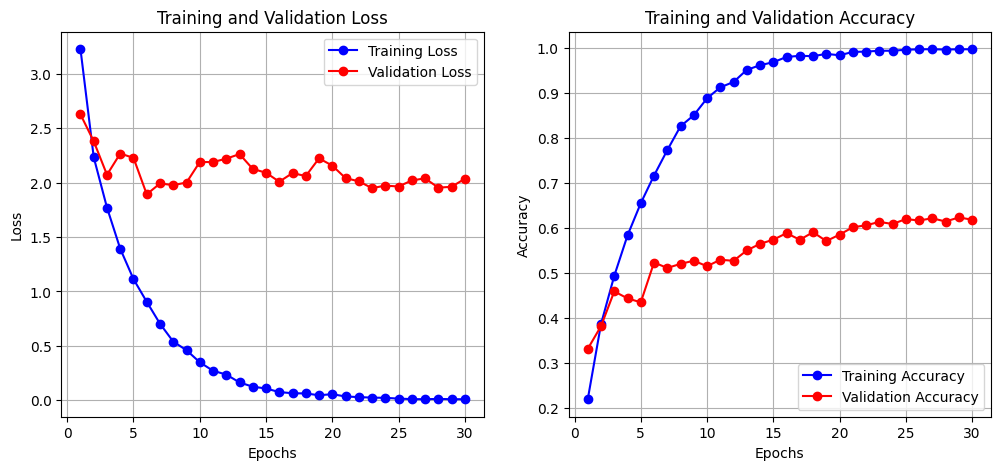

In [9]:
# 학습 과정을 그래프로 시각화하기 위해 train_model 함수를 수정하고 실행하는 코드입니다.

def train_model_with_history(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30):
    # 학습 기록을 저장할 딕셔너리 초기화
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }

    for epoch in range(num_epochs):
        # --- 훈련 단계 (Training Phase) ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # tqdm으로 train_loader를 감싸서 진행 막대 표시
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", unit="batch")
        
        for images, labels, _ in train_loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            # 현재 배치 손실과 평균 손실 업데이트
            current_loss = loss.item()
            avg_running_loss = running_loss / (total / labels.size(0)) # 배치 크기로 나눔 (batch_idx 대신 total 사용)
            train_loop.set_postfix(
                step_loss=f"{current_loss:.4f}",
                avg_loss=f"{running_loss/(train_loop.n+1):.4f}" # tqdm 내부 카운터 사용
            )

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        # 기록 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        print(f"\n✅ [Train] Epoch {epoch+1} 완료 - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

        # --- 검증 단계 (Validation Phase) ---
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        valid_loop = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Valid)", unit="batch")

        with torch.no_grad():
            for images, labels, _ in valid_loop:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                
                valid_loop.set_postfix(loss=f"{loss.item():.4f}")

        valid_loss = running_loss / len(valid_loader)
        valid_acc = correct / total
        
        # 기록 저장
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        
        print(f"⭐ [Validation] Epoch {epoch+1} 완료 - Loss: {valid_loss:.4f}, Accuracy: {valid_acc*100:.2f}%")
        
    return history

# 모델 학습 실행 및 히스토리 저장
history = train_model_with_history(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30) # 에폭 수는 필요에 따라 조정하세요

# 학습 결과 그래프 그리기
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['valid_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['valid_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

# 그래프 출력
plot_training_history(history)

In [10]:
cam_model_path = os.path.join("./class_activation_map/cam_model2.pt")

torch.save(model, cam_model_path)

학습된 모델을 활용하여 cam을 생성

In [11]:
def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

In [12]:
# 원하는 데이터를 골라서 진행해보세요

image, label, bbox = train_dataset[10]
sample_image = image.unsqueeze(0).to(device)

In [13]:
# 모델을 불러오세요

model = torch.load(cam_model_path, weights_only=False)

In [14]:
def generate_cam(model, image):
    model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.detach())
    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    # 예측된 클래스 선택 (배치의 첫 번째 이미지 기준)
    pred_class = output.argmax(dim=1).item()

    # 모델의 fc layer 가중치가 모델과 동일한 디바이스에 있도록 처리
    fc_weights = model.fc.weight.data.to(image.device)

    # features[0]: shape [1, num_features, H, W]
    fmap = features[0][0]  # 첫 번째 이미지의 feature map
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    # CAM 정규화
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

In [15]:
cam = generate_cam(model, sample_image)

In [16]:
def visualize_cam(cam):
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off')
    plt.show()

그려진 cam이미지를 원본 이미지와 합치기

In [17]:
def visualize_cam_on_image(cam, img, alpha=0.5):
    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("CAM Overlay on Image")
    plt.axis('off')
    plt.show()

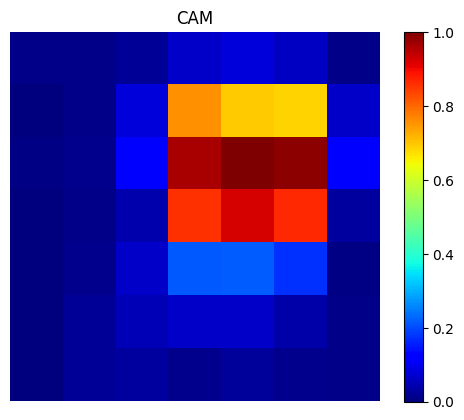

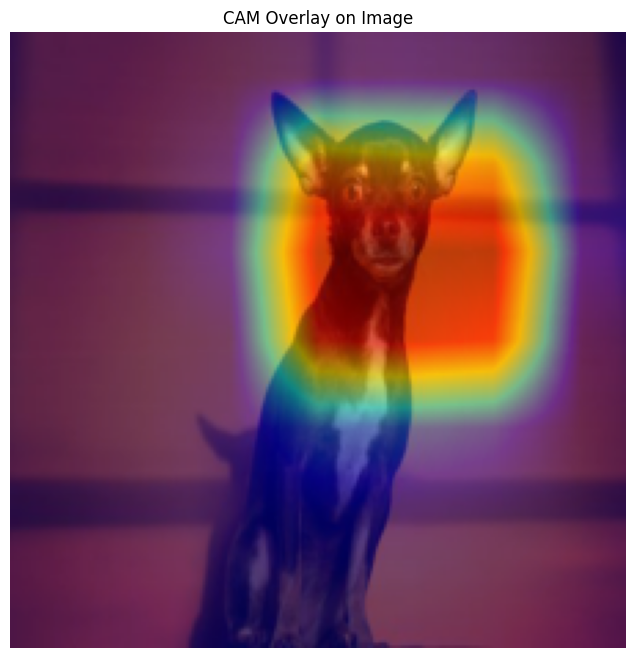

In [18]:
# 원본 이미지 복원
orig_img = unnormalize(image)

# CAM 단독 시각화
visualize_cam(cam)

# 원본 이미지 위에 CAM overlay 시각화
visualize_cam_on_image(cam, orig_img)

grad cam을 이용해서 cam 만들어보기

In [19]:
def generate_grad_cam(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

c:\Users\user\anaconda3\envs\aiffel\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


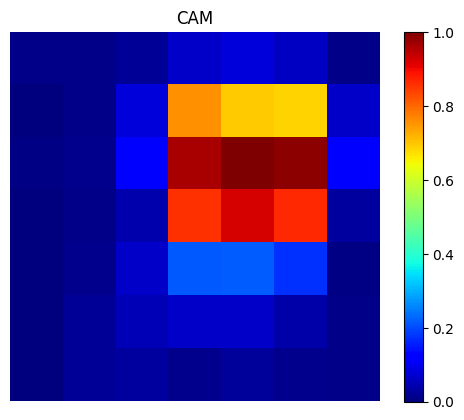

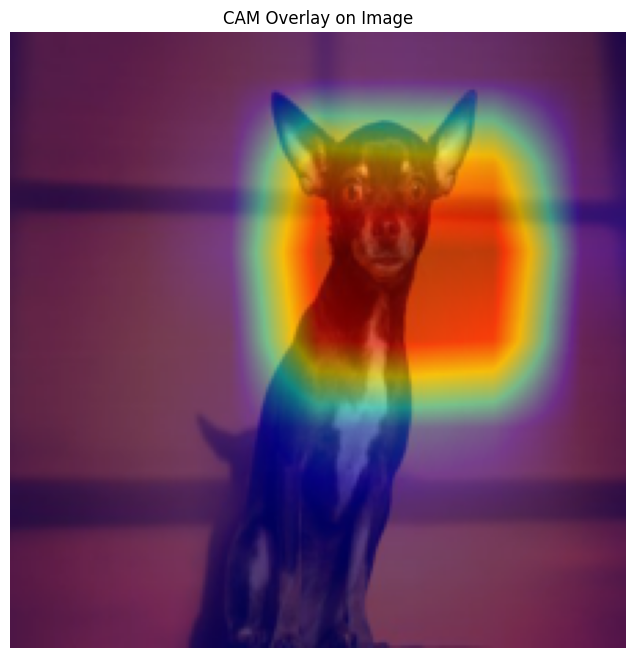

In [20]:
# layer4 사용
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

바운딩 박스

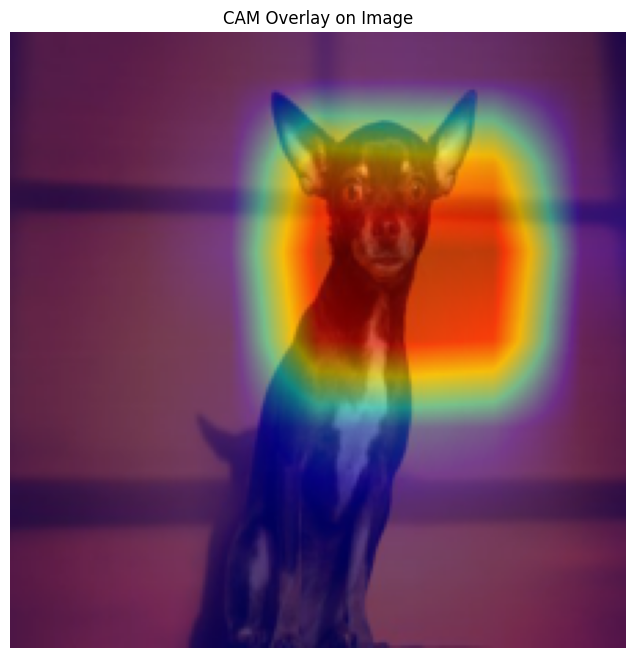

In [21]:
image, label, ground_bbox = train_dataset[10]
sample_image = image.unsqueeze(0).to(device)
orig_img = unnormalize(image)
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

visualize_cam_on_image(grad_cam, orig_img)

In [22]:
def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

In [23]:
cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
bbox = get_bbox(cam_resized, threshold=0.7)

print(bbox)

(np.int64(102), np.int64(45), np.int64(185), np.int64(121))


In [24]:
def visualize_bbox_on_image(img, bbox, box_color=(255, 0, 0), thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

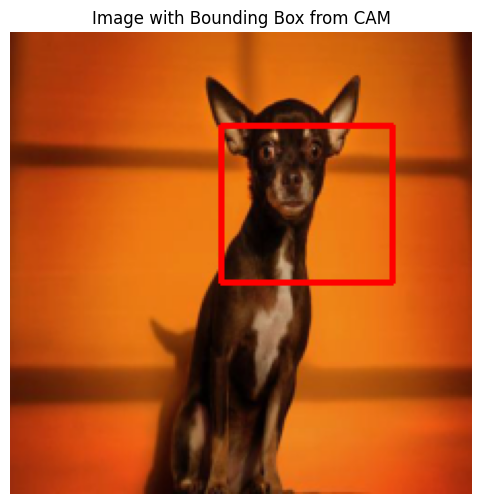

In [25]:
img_bbox = visualize_bbox_on_image(orig_img, bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Image with Bounding Box from CAM")
plt.axis("off")
plt.show()

In [26]:
ground_bbox

[78.848, 19.333333333333332, 169.792, 222.0]

In [27]:
def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [28]:
get_iou(bbox, ground_bbox)


np.float64(0.2630397218744503)

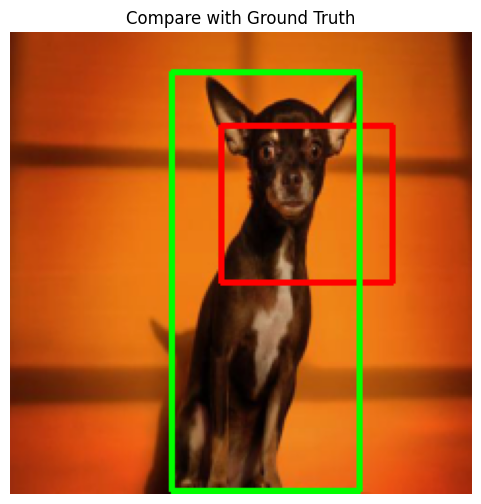

In [29]:
def visualize_both_bbox_on_image(img, bbox, ground_truth, thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()

    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)

    return img_with_bbox

ground_truth = [int(x) for x in ground_bbox]

img_bbox = visualize_both_bbox_on_image(orig_img, bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Compare with Ground Truth")
plt.axis("off")
plt.show()

**결과 비교**

**1. 학습 과정**

![학습과정 그래프](./img1.png)
- 학습 진행 과정을 보면 validation이 조금씩 증가하는것을 볼수있다. Epochs를 추가한다면 성능이 좀더 올라갈수있을것같다.


**2. CAM 방식과 Grad-CAM 방식의 class activation map**

![cam1](./cam1.png)|![grad1](./grad1.png)

![cam2](./cam2.png)|![grad2](./grad2.png)

- 두 방식의 결과를 비교해보면 결과가 매우 비슷한 것을 확인할 수 있었다. GAP이 들어가있어서 그런것으로 추정된다. 
- 추후 GAP이 없는 모델로도 실험해 결과를 같이 비교해보면 좋을것같다.

**3. CAM과 Grad-CAM 성능 비교**

IoU : 0.2630397218744503

![Bounding box](./Bbox.png)

- 정답 Bounding box와 비교를 하면 크기가 차이나지만 강아지의 얼굴 부분은 거의 Bounding box가 겹치는것을 보아 판단하는데 얼굴 부분은 매우 중요하게 여겨지는 것으로 보인다.
- 하지만 IoU가 0.2630397218744503인것을 보면 거의 정답을 맞추지 못했다고 봐도 될것같다.

**4. 회고**
- 히트맵을 통해서 딥러닝 과정에서 이미지의 어떤 부분을 확인해서 분류를 하는지 알게 되었다. 추가로 바운딩 박스로 연결하는 단계 까지 알게 되어 인상깊었다.
- 하지만 생각보다 잘 맞췄다고 생각했는데 IoU값이 너무 작게 나와서 해당 값을 올리는 방법을 좀더 찾아봐야 할것같다.


**5. 추가 실험**
- GAP 제거 모델 실험

![학습 과정](./NOGAP.png)

![NOGAP1](./NOGAP1.png)|![NOGAP2](./NOGAP2.png)


- GAP이 없는 버전을 보면 학습도 거의 아예 진행되지 않은 것을 확인할수 있었다. 
- 코드에 오류가 있는지 다시 확인해 봐야 할것같다.